In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import *
sys.path.append("..")
from audio import *

# Introduction

In this notebook we will build off of the work done on the ESC-50 notebook, but this time using a few more features designed to wrangle a slightly more complex dataset. We will be working with the [Freesound 2018 Kaggle Competition](https://www.kaggle.com/c/freesound-audio-tagging/) in which we attempt to identify audio scenes. This time the classes will be unbalanced, the labels will have some noise, and instead of being fixed-length, the files will vary from 300ms to 30s long, meaning we will have to choose some form of cropping. Our approach will nonetheless be remarkably simple, use very few lines of code, and still achieve top 10 results with a single model (most kaggle winners use ensembling). 

**Warning: I'm still quite inexperienced.** 3-4 months ago I had no clue what a spectrogram or sample rate were. I've been doing machine learning with fastai for 5 months, and my [most recent kaggle result](https://medium.com/@robertbracco1/freesound-kaggle-my-627th-place-solution-a74446f8a6df) is 627th place. There are bound to be mistakes in here but I don't want to let my imperfect knowledge prevent me from sharing what I've learned thus far. Comments, questions and criticism are very appreciated. Please message me [on twitter](https://twitter.com/MadeUpMasters) or [FastAI forums](https://forums.fast.ai/u/MadeUpMasters/) with any corrections or suggestions and I'll happily change them and credit you here.

In [4]:
#!kaggle competitions download -c freesound-audio-tagging

## Grabbing the dataset

The following is directly from the 2019 Part 1, Lesson 3 Planet Notebook from fastai, adjusted for our purposes.

The freesound dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) but you can download it from Kaggle. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [5]:
# ! pip install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [6]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

You're all set to download the data from [Freesound 2018 Kaggle Competition](https://www.kaggle.com/c/freesound-audio-tagging/data). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [7]:
# path = Config.data_path()/'google_speech'
# path.mkdir(parents=True, exist_ok=True)
# path
#!kaggle competitions download -c freesound-audio-tagging

In [8]:
PATH_BASE = Path("/home/jupyter/rob/freesound2018")
PATH_TRAIN = PATH_BASE/"train"
PATH_TEST = PATH_BASE/"test"

FILES_TRAIN = PATH_TRAIN.ls()
FILES_TEST = PATH_TEST.ls()

DF_TRAIN = pd.read_csv(PATH_BASE/"train.csv")
DF_TEST = pd.read_csv(PATH_BASE/"test.csv")
num_train = len(FILES_TRAIN)
num_test = len(FILES_TEST)
num_train, num_test

(9480, 1601)

## Building a Custom Metric

The freesound competition relies on the MAP3 metric, which is the Mean Average Precision over the top 3 predictions. In my understanding, this means that you submit top 3 picks for each item. If your 1st pick is correct, you score 1, if you're 2nd pick is correct you score 0.5, and if your 3rd pick is correct you score 0.33, if the correct class isn't in your top 3 you score 0. You then take your average score across all items and that's MAP3. I think of it like accuracy, but with a few extra guesses for partial credit.

We will an adapt [this github code by Ben Hamner](https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py) to make our own metric that works with fastai. We've altered the default value for k to be 3 so we will be scored on our top 3 picks. It's not super important that you understand the next cell, but make sure to at least read the part where we wrap this to use as a custom fastai metric.

In [9]:
def apk(actual, predicted, k=3):
    actual = [actual]
    if len(predicted)>k: predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
    if not actual: return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

**When using custom metrics, FastAI will expect a function that takes `scores` and `truth` (altered below to be predicted and actual to match Ben's code), and then does something with those values and passes back a result.** That's all. I used to imagine it was complicated but fastai makes it very easy for us.

In our case it is a little complicated because we need to make it compatible with Ben's code, which expects predictions to be ordered, and also works with Python lists and not torch tensors. That means sorting the prediction tensors from highest to lowest (so that Ben's code can easily grab our top 3 picks), and then converting those to python lists, which is what his code expects. 

In [10]:
def MAP3(predicted, actual, **kwargs):
    predicted = torch.argsort(predicted, descending=True)
    mean = mapk(actual.tolist(), predicted.tolist(), k=3)
    return torch.tensor(mean)

## Configuring the Spectrogram and Audio

Again most of these settings are the defaults, but I've left them explicit to show the options. The most important points here are that, because the data is all one sample rate, we don't need to resample. Also since the lengths vary widely, we must choose a duration (in milliseconds). 

In [11]:
sg_cfg= SpectrogramConfig(hop=324, n_mels=128, n_fft=2560, top_db=80, f_min=20, f_max=22050)
cfg = AudioConfig(remove_silence=False, cache=True, segment_size=None, max_to_pad=None, 
                  resample_to=None, duration = 4000, sg_cfg=sg_cfg)

Below is a cool fastai trick I now include every time I train a model. I was inspired after reading [Radek's post on machine learning efficiency](https://hackernoon.com/doing-machine-learning-efficiently-8ba9d9bc679d) where he talks about the importance of using just a small subset of data so you don't have minutes of waiting where you allow yourself to get distracted. The easiest way to implement this is fastai's `use_partial_data`. I usually keep it at 0.05 (5%) for experimenting, and then come back and change it to 1 when I'm ready to train for real. 

In [27]:
data_pct = 1
audio_train = (AudioList.from_csv(PATH_TRAIN, '../train.csv', config=cfg)
                .use_partial_data(data_pct)
                .split_by_rand_pct(0.2)
                .label_from_df())

Because mixup does such an effective job of audio augmentation, we won't use any other transforms. I haven't experimented a ton, but our initial findings are that SpecAugment isn't great for scene recognition, rolling might be good, and changing the size seems to be helpful but our spectrograms are already so large, and our model so deep (densenet161) that we opt not to do it because we are still getting a really good result. 

------------------------------------------------------------
File: /home/jupyter/rob/freesound2018/train/0e7cd4eb.wav
Total Length: 6.08 seconds
Label: Violin_or_fiddle
0.74s-4.74s of original clip


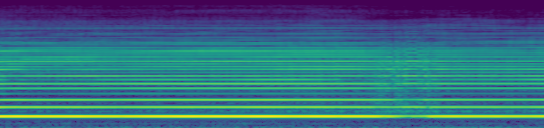

Shape: 128x544
------------------------------------------------------------
File: /home/jupyter/rob/freesound2018/train/3788e6ce.wav
Total Length: 2.06 seconds
Label: Cowbell


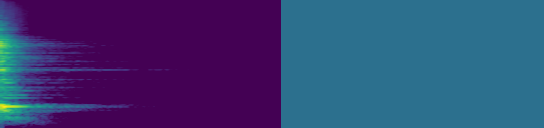

Shape: 128x544
------------------------------------------------------------
File: /home/jupyter/rob/freesound2018/train/a57fa62a.wav
Total Length: 0.84 seconds
Label: Shatter


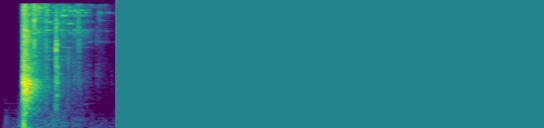

Shape: 128x544
------------------------------------------------------------
File: /home/jupyter/rob/freesound2018/train/d4ebef41.wav
Total Length: 18.08 seconds
Label: Electric_piano
1.15s-5.15s of original clip


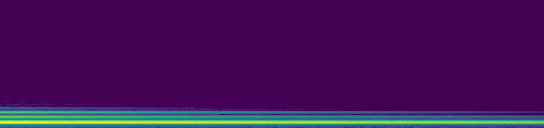

Shape: 128x544
------------------------------------------------------------
File: /home/jupyter/rob/freesound2018/train/fdab5c38.wav
Total Length: 10.18 seconds
Label: Flute
1.75s-5.75s of original clip


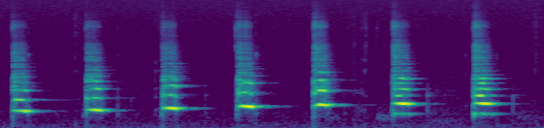

Shape: 128x544
------------------------------------------------------------
File: /home/jupyter/rob/freesound2018/train/31102711.wav
Total Length: 3.98 seconds
Label: Applause


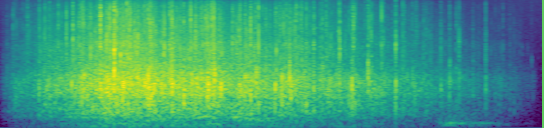

Shape: 128x544
------------------------------------------------------------
File: /home/jupyter/rob/freesound2018/train/9c673f64.wav
Total Length: 4.46 seconds
Label: Shatter
0.24s-4.24s of original clip


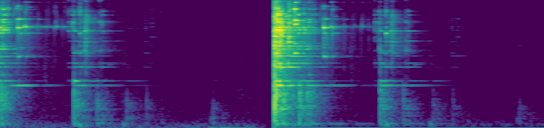

Shape: 128x544
------------------------------------------------------------
File: /home/jupyter/rob/freesound2018/train/7d7b6fe2.wav
Total Length: 1.92 seconds
Label: Acoustic_guitar


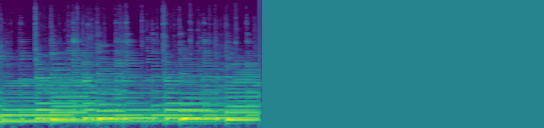

Shape: 128x544


In [28]:
db_audio = audio_train.transform(tfms=None).databunch(bs=16)
db_audio.show_batch(8)

We make sure to pass in our custom metric when creating the learner. We also call .mixup() to automatically add mixup, this is such a cool fastai feature! We use a pretrained model (imagenet) because the competition allows pretrained models as long as they are publicly available and it will speed up training.

**Side note and research opportunity**: For mixup, fastai combines two images additively (for instance 0.8 of one image combined with 0.2 of another), but audio uses a log scale. We've wondered, but haven't tested, whether an audio specific version of mixup that uses log math to combine spectrograms would be somehow more effective. Mixup as is has been so good that we haven't tried it, but if you try it please let us know either way.

In [39]:
learn = audio_learner(db_audio, models.densenet161, metrics=[MAP3], callback_fns=[CSVLogger]).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


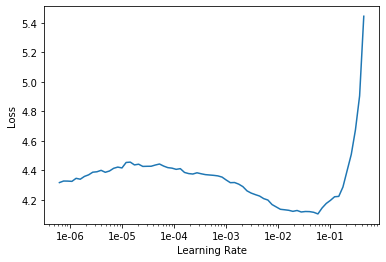

In [30]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(15, max_lr=slice(8e-3), callbacks=[SaveModelCallback(learn, every='improvement', monitor='MAP3')])

Better model found at epoch 0 with MAP3 value: 0.6779303550720215.
Better model found at epoch 1 with MAP3 value: 0.7206969261169434.
Better model found at epoch 2 with MAP3 value: 0.7553679943084717.
Better model found at epoch 3 with MAP3 value: 0.7615275382995605.
Better model found at epoch 4 with MAP3 value: 0.8131819367408752.
Better model found at epoch 5 with MAP3 value: 0.8276135325431824.
Better model found at epoch 6 with MAP3 value: 0.8459171652793884.
Better model found at epoch 8 with MAP3 value: 0.8538366556167603.
Better model found at epoch 9 with MAP3 value: 0.8625485301017761.
Better model found at epoch 10 with MAP3 value: 0.8667723536491394.
Better model found at epoch 11 with MAP3 value: 0.8744282126426697.
Better model found at epoch 12 with MAP3 value: 0.8784760236740112.
Better model found at epoch 14 with MAP3 value: 0.8853397965431213.


In [41]:
learn.export(PATH_BASE/f"models/train-rd1.pkl")

In [ ]:
learn.fit_one_cycle(15, max_lr=slice(5e-3), callbacks=[SaveModelCallback(learn, every='improvement', monitor='MAP3')])

Better model found at epoch 0 with MAP3 value: 0.8752201199531555.
Better model found at epoch 1 with MAP3 value: 0.8814679384231567.
Better model found at epoch 9 with MAP3 value: 0.886043906211853.
Better model found at epoch 11 with MAP3 value: 0.887539803981781.
Better model found at epoch 12 with MAP3 value: 0.8907956480979919.


In [ ]:
learn.export(PATH_BASE/f"models/train-rd2.pkl")

In [35]:
learn.export(PATH_BASE/"models/dn161-4s-reproducible-rd1.pkl")

In [36]:
learn.fit_one_cycle(5, max_lr=slice(4e-3))

In [37]:
learn.export(PATH_BASE/"models/dn161-4s-reproducible-rd2.pkl")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


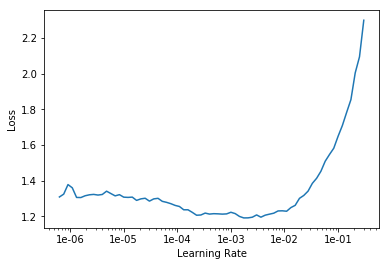

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(5, max_lr=slice(3e-3), callbacks=[SaveModelCallback(learn, every='improvement', monitor='MAP3')])

Better model found at epoch 0 with MAP3 value: 0.8773319721221924.
Better model found at epoch 3 with MAP3 value: 0.8885957598686218.


In [41]:
learn.export(PATH_BASE/"models/dn161-4s-reproducible-rd3.pkl")

In [42]:
learn = load_learner('/home/jupyter/rob/freesound2018/models', 'dn161-4s-reproducible-rd3.pkl')

In [43]:
learn.data=db_audio

In [44]:
learn.fit_one_cycle(20, max_lr=slice(1e-3), callbacks=[SaveModelCallback(learn, every='improvement', monitor='MAP3')], div_factor=5)

Better model found at epoch 0 with MAP3 value: 0.884723961353302.
Better model found at epoch 6 with MAP3 value: 0.8869239091873169.
Better model found at epoch 10 with MAP3 value: 0.8900916576385498.
Better model found at epoch 12 with MAP3 value: 0.8937875628471375.
Better model found at epoch 13 with MAP3 value: 0.8988034129142761.
Better model found at epoch 14 with MAP3 value: 0.8996833562850952.
Better model found at epoch 18 with MAP3 value: 0.9003873467445374.


In [45]:
learn.export(PATH_BASE/"models/dn161-4s-reproducible-rd4.pkl")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


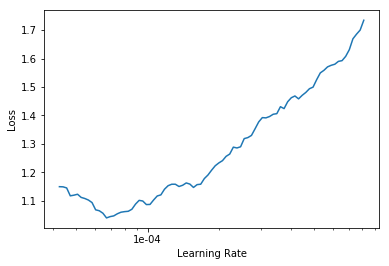

In [59]:
learn.lr_find(start_lr=3e-05, end_lr=1e-03); learn.recorder.plot()

In [27]:
learn = load_learner('/home/jupyter/rob/freesound2018/models', 'dn161-4s-reproducible-rd4.pkl')

In [31]:
path_best = "/home/jupyter/rob/freesound2018/models/models/bestmodel"
learn = load_learner('/home/jupyter/rob/freesound2018/models', 'dn161-4s-reproducible-rd3.pkl')
def self_train(learn):
#     learn.fit_one_cycle(40, max_lr=slice(3e-3, 3e-2), callbacks=[SaveModelCallback(learn, every='improvement', monitor='MAP3')])
#     learn.load(path_best)
#     learn.export(PATH_BASE/"models/self-train-rd1.pkl")

    for i in range(10):
        try:
            run_cycle(learn, i)
        except RuntimeError:
            learn.destroy()
            torch.cuda.empty_cache()
            learn = audio_learner(db_audio, models.densenet161, metrics=[mapk.MAP3], callback_fns=[CSVLogger]).mixup()
            run_cycle(learn, i)
    
    #!sudo shutdown -h now
def run_cycle(lrn, i):
    lrn.load(path_best)
    lrn.unfreeze()
    lrn.fit_one_cycle(30, max_lr=slice(2e-4), callbacks=[SaveModelCallback(learn, every='improvement', monitor='MAP3')], div_factor=5)
    lrn.load(path_best)
    lrn.export(PATH_BASE/f"models/dn161-4s-reproducible-selftrain-{i+6}.pkl")

In [ ]:
learn = audio_learner(db_audio, models.densenet161, metrics=[mapk.MAP3], callback_fns=[CSVLogger]).mixup()
learn.fit_one_cycle(15, max_lr=slice(5e-3), callbacks=[SaveModelCallback(learn, every='improvement', monitor='MAP3')])
learn.export(PATH_BASE/f"models/dn161-4s-new_train-rd1.pkl")
learn.fit_one_cycle(15, max_lr=slice(3e-3), callbacks=[SaveModelCallback(learn, every='improvement', monitor='MAP3')])
learn.export(PATH_BASE/f"models/dn161-4s-new_train-rd2.pkl")
learn.fit_one_cycle(15, max_lr=slice(2e-3), callbacks=[SaveModelCallback(learn, every='improvement', monitor='MAP3')])
learn.export(PATH_BASE/f"models/dn161-4s-new_train-rd3.pkl")
learn.unfreeze()
learn.fit_one_cycle(30, max_lr=slice(1e-3))
learn.export(PATH_BASE/f"models/dn161-4s-new_train-rd4.pkl")
learn.fit_one_cycle(30, max_lr=slice(6e-4), callbacks=[SaveModelCallback(learn, every='improvement', monitor='MAP3')])
learn.export(PATH_BASE/f"models/dn161-4s-new_train-rd5.pkl")

Better model found at epoch 0 with MAP3 value: 0.6825229525566101.
Better model found at epoch 1 with MAP3 value: 0.7346723675727844.
Better model found at epoch 2 with MAP3 value: 0.7811839580535889.
Better model found at epoch 3 with MAP3 value: 0.8012685179710388.
Better model found at epoch 4 with MAP3 value: 0.8498943448066711.
Better model found at epoch 5 with MAP3 value: 0.8639886379241943.
Better model found at epoch 7 with MAP3 value: 0.8791402578353882.
Better model found at epoch 8 with MAP3 value: 0.8890063166618347.
Better model found at epoch 9 with MAP3 value: 0.8921776413917542.
Better model found at epoch 11 with MAP3 value: 0.9023960828781128.
Better model found at epoch 12 with MAP3 value: 0.9112050533294678.


Better model found at epoch 0 with MAP3 value: 0.9073290824890137.
Better model found at epoch 6 with MAP3 value: 0.9119097590446472.
Better model found at epoch 14 with MAP3 value: 0.918956995010376.


Better model found at epoch 0 with MAP3 value: 0.9231853485107422.


Better model found at epoch 0 with MAP3 value: 0.9270614385604858.
Better model found at epoch 1 with MAP3 value: 0.9298801422119141.


In [ ]:
self_train(learn)

Better model found at epoch 0 with MAP3 value: 0.9807286858558655.
Better model found at epoch 2 with MAP3 value: 0.9813446998596191.
Better model found at epoch 5 with MAP3 value: 0.9824886322021484.


Better model found at epoch 0 with MAP3 value: 0.9796727299690247.
Better model found at epoch 1 with MAP3 value: 0.9815207123756409.


In [35]:
learn.data

AttributeError: valid_ds

In [28]:
learn.fit_one_cycle(100, max_lr=slice(1e-3), div_factor=5)

In [30]:
learn.fit_one_cycle(40, max_lr=slice(1e-3), div_factor=5)

In [68]:
learn2.data = db_audio

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


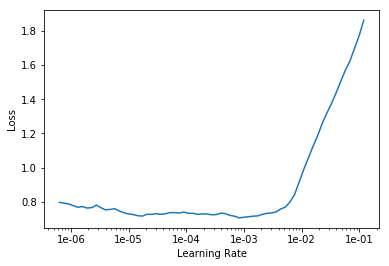

In [59]:
learn2.lr_find(); learn2.recorder.plot()

In [34]:
learn.export('/home/jupyter/rob/freesound2018/fat18-mixup-rd2.pkl')

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

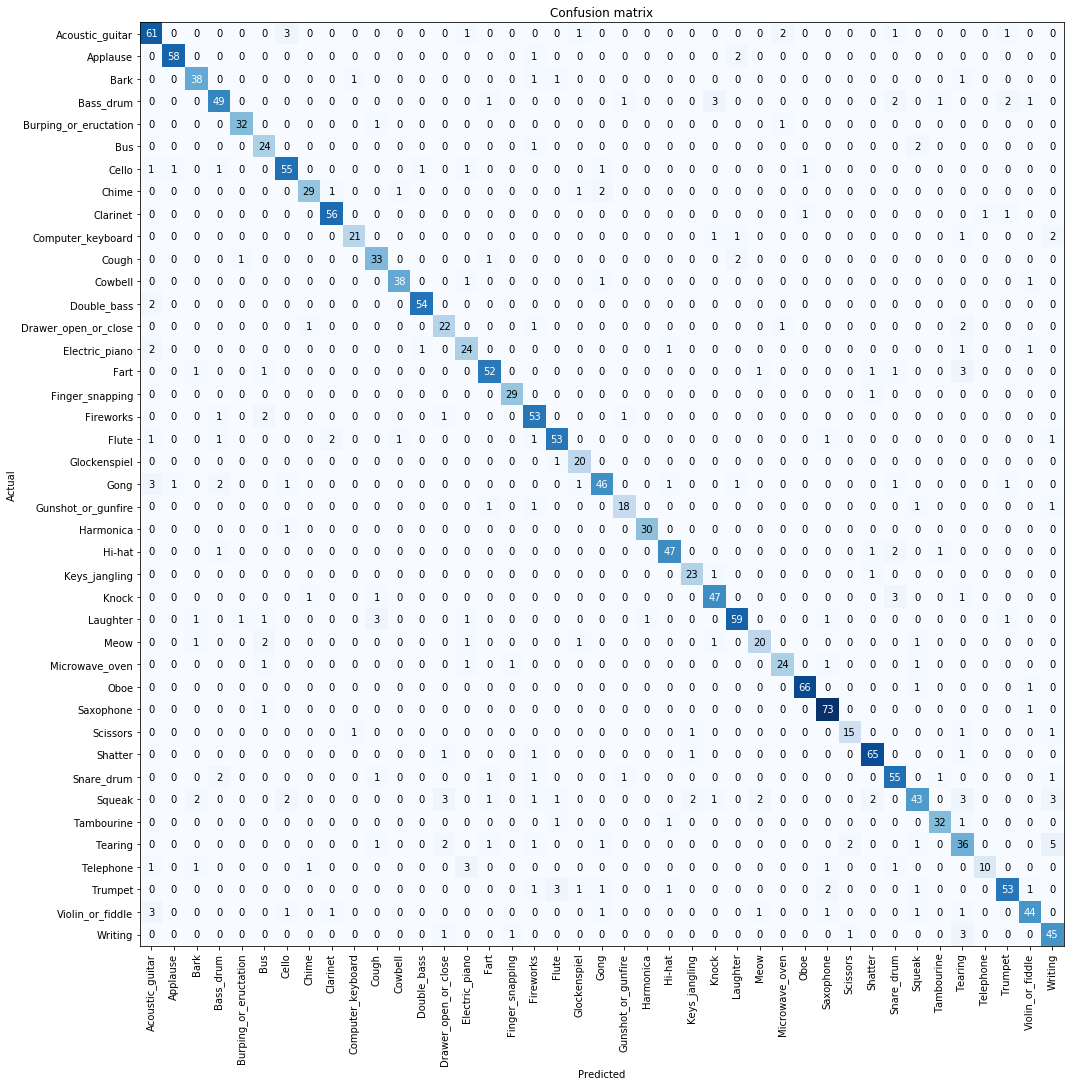

In [31]:
from matplotlib.pyplot import figure
interp.plot_confusion_matrix(figsize=(15,15))

In [32]:
interp.most_confused()

[('Tearing', 'Writing', 5),
 ('Acoustic_guitar', 'Cello', 3),
 ('Bass_drum', 'Knock', 3),
 ('Fart', 'Tearing', 3),
 ('Gong', 'Acoustic_guitar', 3),
 ('Knock', 'Snare_drum', 3),
 ('Laughter', 'Cough', 3),
 ('Squeak', 'Drawer_open_or_close', 3),
 ('Squeak', 'Tearing', 3),
 ('Squeak', 'Writing', 3),
 ('Telephone', 'Electric_piano', 3),
 ('Trumpet', 'Flute', 3),
 ('Violin_or_fiddle', 'Acoustic_guitar', 3),
 ('Writing', 'Tearing', 3),
 ('Acoustic_guitar', 'Microwave_oven', 2),
 ('Applause', 'Laughter', 2),
 ('Bass_drum', 'Snare_drum', 2),
 ('Bass_drum', 'Trumpet', 2),
 ('Bus', 'Squeak', 2),
 ('Chime', 'Gong', 2),
 ('Computer_keyboard', 'Writing', 2),
 ('Cough', 'Laughter', 2),
 ('Double_bass', 'Acoustic_guitar', 2),
 ('Drawer_open_or_close', 'Tearing', 2),
 ('Electric_piano', 'Acoustic_guitar', 2),
 ('Fireworks', 'Bus', 2),
 ('Flute', 'Clarinet', 2),
 ('Gong', 'Bass_drum', 2),
 ('Hi-hat', 'Snare_drum', 2),
 ('Meow', 'Bus', 2),
 ('Snare_drum', 'Bass_drum', 2),
 ('Squeak', 'Bark', 2),
 ('Sque

In [38]:
test = AudioList.from_folder(PATH_TEST, config=cfg)

In [39]:
test

AudioList (1600 items)
AudioItem 0.4 seconds (17640 samples @ 44100hz),AudioItem 6.12 seconds (269892 samples @ 44100hz),AudioItem 1.3 seconds (57330 samples @ 44100hz),AudioItem 5.5 seconds (242550 samples @ 44100hz),AudioItem 1.14 seconds (50274 samples @ 44100hz)
Path: /home/jupyter/rob/freesound2018/test

In [19]:
test[1]

AudioItem AudioItem 6.12 seconds (269892 samples @ 44100hz)

In [40]:
learn2 = load_learner('/home/jupyter/rob/freesound2018/', 'fat18-mixup-rd2.pkl', test=test)

In [41]:
learn2.predict(test[1])

(Category Trumpet,
 tensor(38),
 tensor([8.8657e-04, 5.2756e-04, 5.4707e-04, 3.9494e-03, 2.2825e-03, 8.1375e-05,
         1.1651e-03, 5.0652e-04, 4.2599e-04, 1.1901e-04, 1.2648e-03, 1.1263e-03,
         1.2050e-03, 1.1543e-03, 1.0930e-03, 1.8976e-04, 3.5115e-04, 2.0342e-03,
         8.8099e-04, 1.3898e-03, 8.2814e-04, 6.9843e-04, 4.3698e-04, 2.8103e-03,
         4.6450e-05, 9.3257e-04, 8.2046e-04, 5.5520e-04, 4.6517e-04, 2.2895e-03,
         7.1044e-04, 4.5248e-04, 1.2550e-03, 1.7532e-03, 2.1499e-03, 1.0583e-03,
         2.6738e-04, 3.9041e-04, 9.5996e-01, 5.4448e-04, 3.9380e-04]))

In [22]:
type(learn2)

fastai.basic_train.Learner

In [21]:
learn2.window_predict()

AttributeError: 'Learner' object has no attribute 'window_predict'

In [82]:
cfg._sr=44100

In [79]:
test[10]

AudioItem AudioItem 13.36 seconds (589176 samples @ 44100hz)

In [50]:
def predict_windowed_test_set():
    final_preds = []
    for i in range(len(test)):
        print(i)
        preds_list = []
        for _ in range(3):
            item = test[i]
            #print(str(test[i].path).split('/')[-1])
            preds = learn2.predict(item)
            preds_list.append(preds[2])
            #print(preds[0])
        final_preds.append(sum(preds_list)/len(preds_list))
    return torch.stack(final_preds)

In [51]:
final_preds = predict_windowed_test_set()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [93]:
len(final_preds)

1600

In [100]:
learn2.data.classes[final_preds[0].argmax()]

'Hi-hat'

In [59]:
test[0].sr

cropping
padding


44100

In [60]:
cfg._sr = 44100

In [48]:
cfg.duration

4

In [99]:
str(test[0].path).split('/')[-1]

'856739f7.wav'

In [52]:
with open("submission.csv", 'w') as f:
    f.write("fname,label\n")
    for i, pred in enumerate(final_preds):
        f.write(f"{str(test[i].path).split('/')[-1]},{learn2.data.classes[final_preds[i].argmax()]}\n")
    for tf in TEST_FILES_EXTRA:
        f.write(f"{str(tf)},None\n")

In [53]:
df = pd.read_csv("submission.csv")

In [54]:
df.head()

fname    label
0  856739f7.wav   Hi-hat
1  81739d68.wav  Trumpet
2  96205cdd.wav  Trumpet
3  e35f12f0.wav    Flute
4  895edd06.wav  Cowbell

In [26]:
df_test = pd.read_csv('test_post_competition.csv')

In [29]:
TEST_FILES_EXTRA = [f for f in df_test.loc[df_test['label'] == "None"].fname]

In [27]:
df_test

fname               label    usage  freesound_id  \
0     00063640.wav                None  Ignored         88926   
1     0013a1db.wav                None  Ignored        373335   
2     002bb878.wav                None  Ignored        189611   
3     002d392d.wav                None  Ignored         35939   
4     00326aa9.wav                Oboe  Private        355125   
5     0038a046.wav           Bass_drum  Private         90621   
6     003995fa.wav                None  Ignored        236848   
7     005ae625.wav                None  Ignored        353496   
8     007759c4.wav           Saxophone  Private         13406   
9     008afd93.wav           Saxophone  Private        358962   
10    00a161c0.wav                None  Ignored        247506   
11    00a7a2f6.wav                None  Ignored        356805   
12    00ae03f6.wav               Chime  Private         78203   
13    00b2404e.wav                None  Ignored        357923   
14    00beb030.wav                None  Ignored        372943   
15    00c4d5b8.wav                None  Ignored        251019   
16    00c92c05.wav                None  Ignored        183752   
17    00ccf065.wav                None  Ignored        344759   
18    00d0ab77.wav                None  Ignored        357000   
19    00dffe3a.wav                None  Ignored         83154   
20    00e33205.wav                None  Ignored        357012   
21    00e7ed07.wav                None  Ignored        354446   
22    00eac343.wav      Electric_piano   Public        371494   
23    00f2f692.wav                None  Ignored        138740   
24    0102a895.wav                None  Ignored        247959   
25    010a0b3a.wav             Shatter  Private        368342   
26    010eed01.wav                None  Ignored         10811   
27    01115622.wav                None  Ignored        368341   
28    01198b7e.wav                None  Ignored        356811   
29    01207ce5.wav                None  Ignored        156245   
...            ...                 ...      ...           ...   
9370  ff812cf5.wav           Bass_drum  Private        186308   
9371  ff81cc5d.wav           Saxophone  Private        358918   
9372  ff85f513.wav                None  Ignored        143487   
9373  ff8c555d.wav  Gunshot_or_gunfire  Private        128299   
9374  ff8cfb2d.wav         Double_bass  Private        203817   
9375  ff927bb1.wav                None  Ignored        249062   
9376  ff96680f.wav                Meow  Private        352227   
9377  ff97972c.wav                None  Ignored        248898   
9378  ffa502ed.wav                None  Ignored        249018   
9379  ffa69cfc.wav           Telephone  Private         66290   
9380  ffaca82d.wav            Scissors   Public        332471   
9381  ffae796c.wav                None  Ignored        357840   
9382  ffb6eb52.wav             Cowbell  Private         91139   
9383  ffb6f4da.wav                None  Ignored        348785   
9384  ffb75ce0.wav                None  Ignored        183795   
9385  ffba7963.wav            Clarinet  Private        248994   
9386  ffbc5fb8.wav                None  Ignored        358105   
9387  ffbe4fbf.wav                None  Ignored        357875   
9388  ffc9555f.wav                None  Ignored         88803   
9389  ffd137a4.wav                None  Ignored        183805   
9390  ffd48624.wav                None  Ignored        374066   
9391  ffd5e900.wav                None  Ignored        357421   
9392  ffd64be4.wav                None  Ignored        120177   
9393  ffd6e84f.wav                None  Ignored         45491   
9394  ffd9d282.wav                None  Ignored        356748   
9395  ffe76321.wav                None  Ignored        211012   
9396  ffe8d42d.wav                None  Ignored        251879   
9397  ffeba2cd.wav                None  Ignored        247917   
9398  fff6d073.wav                None  Ignored        209571   
9399  fff8d22d.wav                None  Ignored 

In [31]:
len(TEST_FILES_EXTRA)

7800

In [33]:
df = pd.read_csv("submission.csv")

In [34]:
df

fname     label
0     856739f7.wav    Hi-hat
1     81739d68.wav    Hi-hat
2     96205cdd.wav   Trumpet
3     e35f12f0.wav   Trumpet
4     895edd06.wav   Trumpet
5     58663e0d.wav     Flute
6     0db65bf4.wav     Flute
7     116b77d5.wav     Flute
8     fea0565a.wav     Flute
9     853939b1.wav     Flute
10    1779afe8.wav     Flute
11    98b3bf67.wav     Flute
12    7fe3251a.wav     Flute
13    492bacbe.wav     Flute
14    597dc329.wav     Flute
15    15bfb7ad.wav     Flute
16    41ee0c63.wav     Flute
17    bf05bec8.wav  Laughter
18    4a6014e0.wav     Flute
19    6ffaaf83.wav     Flute
20    0038a046.wav     Flute
21    2d6de409.wav   Trumpet
22    dd07144f.wav   Trumpet
23    d129bdd6.wav  Laughter
24    73bae886.wav  Laughter
25    a0152732.wav   Trumpet
26    3ad731d5.wav   Trumpet
27    c14b528c.wav   Trumpet
28    8d13a005.wav   Trumpet
29    a4265282.wav   Trumpet
...            ...       ...
9370  ff3cabc7.wav      None
9371  ff3e8bef.wav      None
9372  ff4f75ba.wav      None
9373  ff551f5a.wav      None
9374  ff5e724e.wav      None
9375  ff5fde1a.wav      None
9376  ff66d0a1.wav      None
9377  ff70ba03.wav      None
9378  ff732a68.wav      None
9379  ff85f513.wav      None
9380  ff927bb1.wav      None
9381  ff97972c.wav      None
9382  ffa502ed.wav      None
9383  ffae796c.wav      None
9384  ffb6f4da.wav      None
9385  ffb75ce0.wav      None
9386  ffbc5fb8.wav      None
9387  ffbe4fbf.wav      None
9388  ffc9555f.wav      None
9389  ffd137a4.wav      None
9390  ffd48624.wav      None
9391  ffd5e900.wav      None
9392  ffd64be4.wav      None
9393  ffd6e84f.wav      None
9394  ffd9d282.wav      None
9395  ffe76321.wav      None
9396  ffe8d42d.wav      None
9397  ffeba2cd.wav      None
9398  fff6d073.wav      None
9399  fff8d22d.wav      None

[9400 rows x 2 columns]